# Analyzing and tuning a transmon qubit
### Prerequisite
A working local installation of Ansys

### Transmon only: render into Ansys.
1. Run finite element eigenmode analysis. <br>
1. Plot fields and display them. <br>
1. Set up EPR junction dictionary. <br>
1. Run EPR analysis on single mode. <br>
1. Get qubit freq and anharmonicity. <br>
1. Calculate EPR of substrate.  <br>
1. Render to Ansys Q3D. <br>
1. Calculate the capacitance matrix. <br>

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

In [2]:
%metal_heading Create a single transmon qubit 

### Create the design in Metal
Setup a design of a given dimension. Dimensions will be respected in the design rendering.

In [3]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'
hfss = design.renderers.hfss

gui = MetalGUI(design)

Create a single transmon with one readout resonator and move it to the center of the chip previously defined.

In [4]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

gui.rebuild()
gui.autoscale()

### Establish a connection between Metal and Ansys
First you will need to open Ansys. <br>
You can either open Ansys manually, or by executing one of the lines in the following cell. <br>
open_ansys() will look by default for the 2021 R2 version of Ansys. You can easily reroute it to your Ansys of choice by providing the name of the environment variable that contains the path (path_env) or the path itself (path)

In [5]:
hfss.open_ansys()   # this opens Ansys 2021 R2 if present
# hfss.open_ansys(path_var='ANSYSEM_ROOT211')
# hfss.open_ansys(path='C:\Program Files\AnsysEM\AnsysEM21.1\Win64')
# hfss.open_ansys(path='../../../Program Files/AnsysEM/AnsysEM21.1/Win64')

If a project was not automatically opened, you can manually create/open one from the Ansys GUI. Alternatively you can execute the following cell.

In [6]:
# hfss.new_ansys_project()

Finally connect this Jupyter Notebook session with the active Ansys project.

In [7]:
hfss.connect_ansys()
# hfss.connect_ansys('C:\\project_path\\', 'Project1')  # will open a saved project before linking the Jupyter session

INFO 01:35PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:35PM [load_ansys_project]: 	Opened Ansys App
INFO 01:35PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 01:35PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project16
INFO 01:35PM [connect_design]: No active design found (or error getting active design).
INFO 01:35PM [connect]: 	 Connected to project "Project16". No design detected


### Prepare and run the analysis

Create and activate an eigenmode design called "TransmonQubit".

In [8]:
hfss.activate_eigenmode_design("TransmonQubit")

01:35PM 01s WARNING [activate_eigenmode_design]: The name=TransmonQubit was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 01:35PM [connect_design]: 	Opened active design
	Design:    TransmonQubit [Solution type: Eigenmode]
WARNING 01:35PM [connect_setup]: 	No design setup detected.
WARNING 01:35PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


Render the single qubit in Metal, called Q1, to "TransmonQubit" design in Ansys.

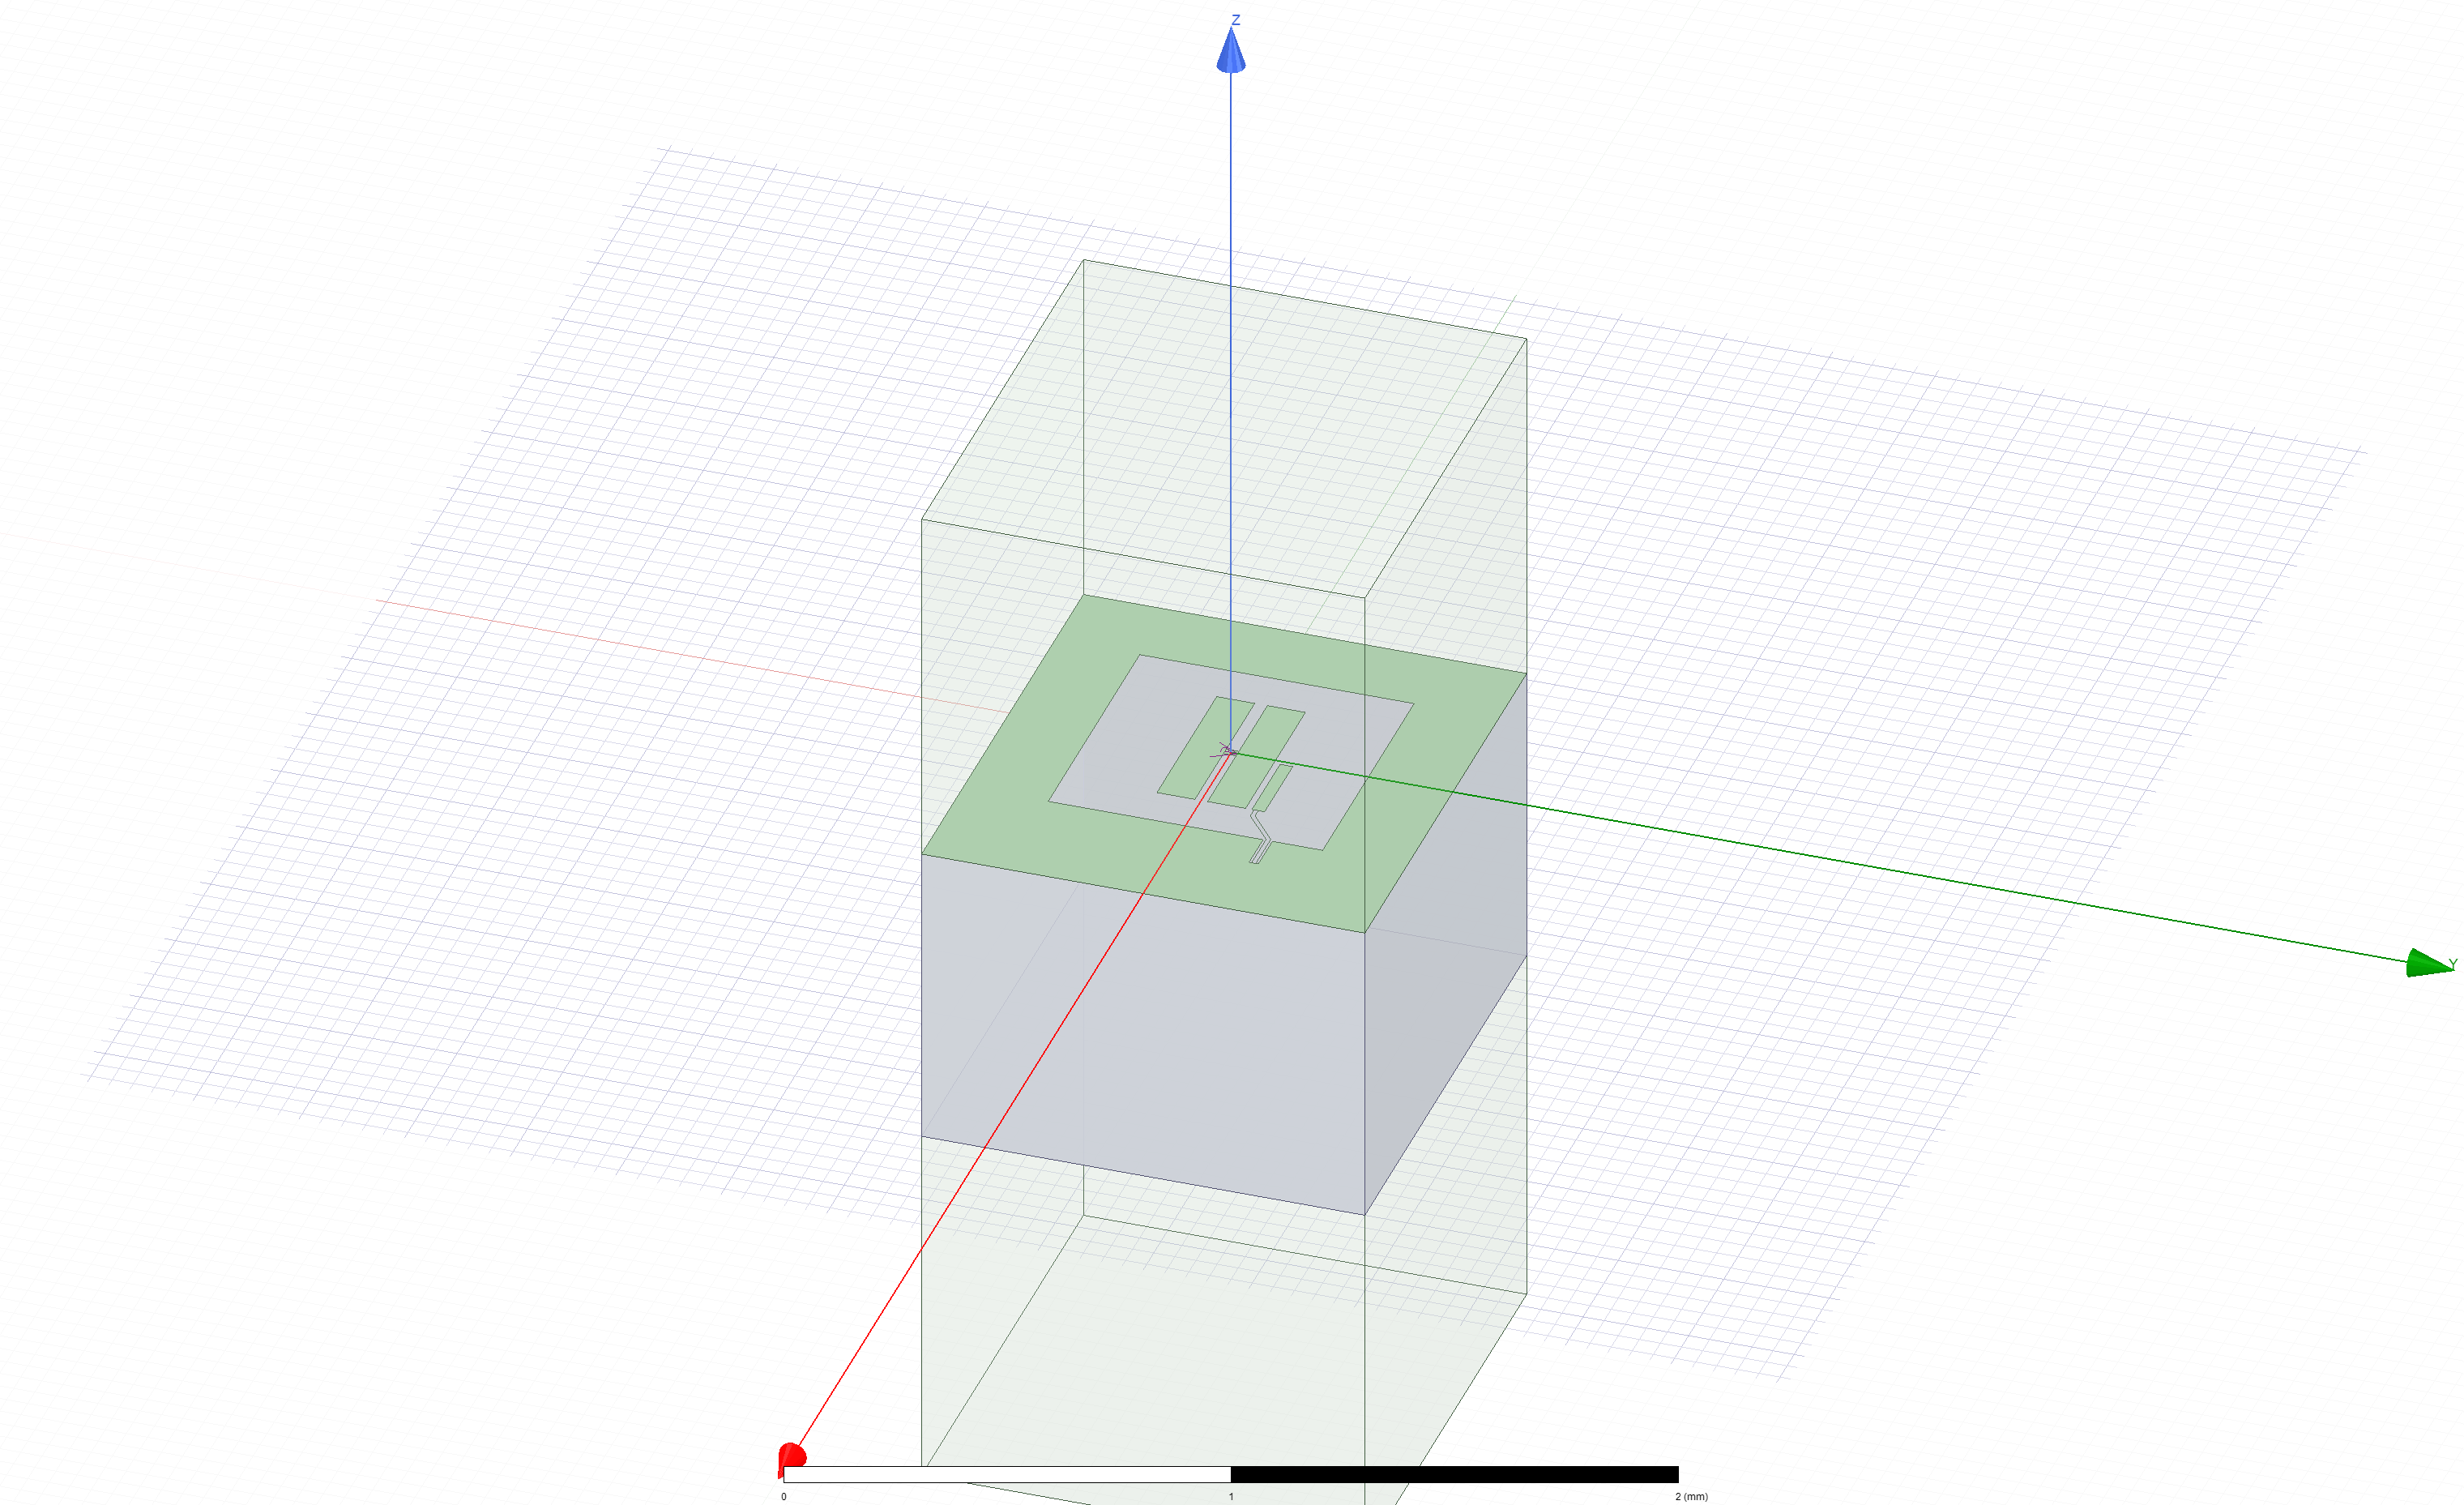

In [9]:
hfss.render_design(['Q1'], [])
hfss.save_screenshot()

Set the convergence parameters and junction properties in the Ansys design. <br>
Then run the analysis and plot the convergence.

In [10]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 10
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 01:35PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



01:36PM 21s INFO [hfss_report_f_convergence]: Saved convergences to C:\workspace\qiskit-metal\docs\tut\4 Analysis\hfss_eig_f_convergence.csv


### Plot fields and display them
Display the Ansys modeler window and plot the E-field on the chip's surface.

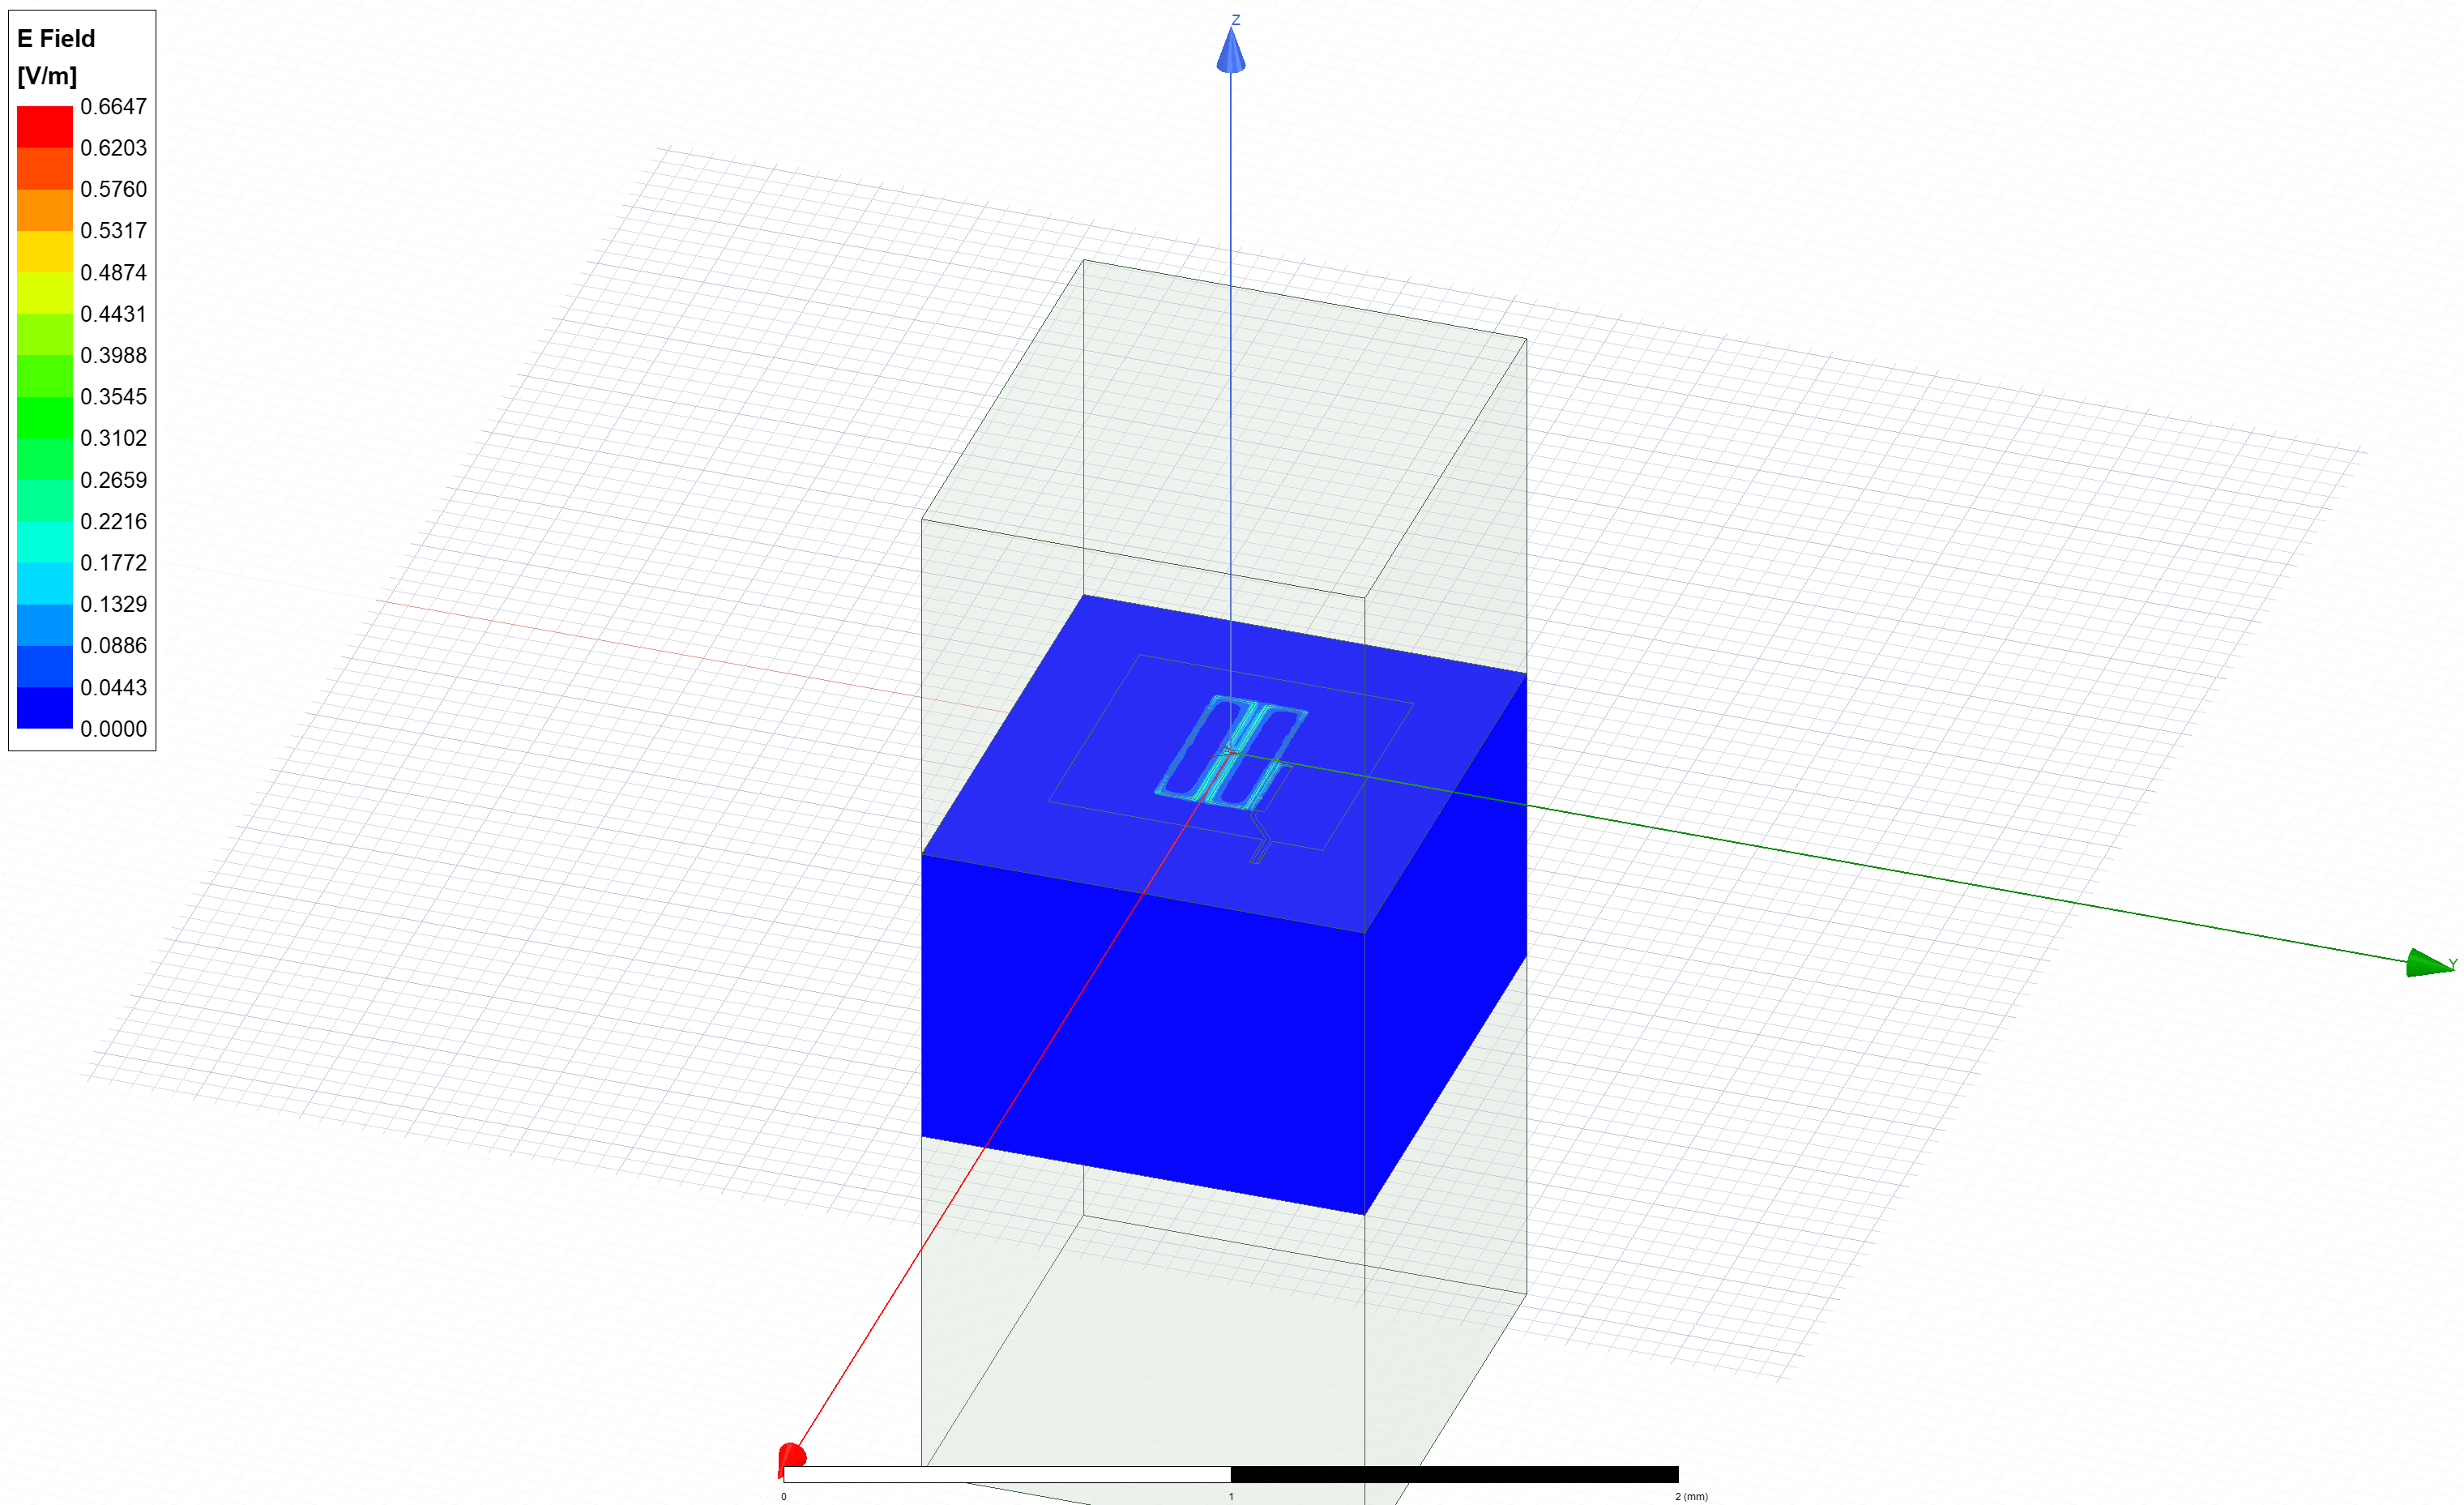

WindowsPath('C:/workspace/qiskit-metal/docs/tut/4 Analysis/ansys.png')

In [11]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

Delete the newly created E-field plot to prepare for the next phase.

In [12]:
hfss.plot_ansys_delete(['Mag_E1'])

In [13]:
%metal_print Energy-Participation-Ratio Analysis

### Set up EPR parameters
Specify the junctions in the model; in this case there's only one, namely 'jj'.

In [14]:
#Non-linear (Josephson) junction
pinfo = hfss.pinfo # Project info
pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj', 
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify
# Handles  microwave analysis on eigenmode solutions
eprd = epr.DistributedAnalysis(pinfo)

Design "TransmonQubit" info:
	# eigenmodes    1
	# variations    1


Find the electric and magnetic energy stored in the substrate and the system as a whole.

In [15]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag    = {ℰ_mag}
""")


ℰ_elec_all       = 9.6815388026089e-25
ℰ_elec_substrate = 8.91706074244016e-25
EPR of substrate = 92.1%

ℰ_mag    = 2.44586411178151e-26



### Run EPR analysis

Perform EPR analysis for all modes and variations.

In [16]:
eprd.do_EPR_analysis()

# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

# 4b. Report solved results
swp_variable = 'Lj' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)


Variation 0  [1/1]

  Mode 0 at 6.36 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.5%  4.841e-25 1.223e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.90%
	jj              0.994495  (+)        0.0318047
		(U_tot_cap-U_tot_ind)/mean=0.59%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9210375462253237


WARNING 01:36PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project16\TransmonQubit\2021-06-28 13-36-27.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.011964
dtype: float64

Pm_norm idx =
     jj
0  True
*** P (participation matrix, not normlz.)
         jj
0  0.963841

*** S (sign-bit matrix)
   s_jj
0     1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       295

*** Chi matrix ND (MHz) 
       326

*** Frequencies O1 PT (MHz)
0    6069.617909
dtype: float64

*** Frequencies ND (MHz)
0    6054.749316
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,6069.62


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj,,
10,0,325.92


Release Ansys session

In [17]:
hfss.disconnect_ansys()

In [18]:
%metal_print Q3D Analysis

Next we will look at a lumped oscillator model (LOM) for the same design.

## Render to Ansys Q3D

In [19]:
q3d = design.renderers.q3d

Again, we establish a connection with Ansys and add a design.

In [20]:
q3d.connect_ansys()
q3d.activate_q3d_design("TransmonQubit_q3d")

INFO 01:36PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:36PM [load_ansys_project]: 	Opened Ansys App
INFO 01:36PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 01:36PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project16
INFO 01:36PM [connect_design]: 	Opened active design
	Design:    TransmonQubit [Solution type: Eigenmode]
INFO 01:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:36PM [connect]: 	Connected to project "Project16" and design "TransmonQubit" 😀 

01:36PM 34s WARNING [activate_q3d_design]: The name=TransmonQubit_q3d was not in active project.  A new design will be inserted to the project.  Names in active project are: 
['TransmonQubit'].  
INFO 01:36PM [connect_design]: 	Opened active design
	Design:    TransmonQubit_q3d [Solution type: Q3D]
WARNING 01:36PM [connect_setup]: 	No design setup detected.
WARNING 01:36PM [connect_setup]: 	Creating Q3D default setup.
INFO 01:3

Next, we render the qubit to Ansys Q3D for analysis. We set the readout pin of the qubit in the 'open' termination list of the render so its capacitance is properly simulated.

In [21]:
q3d.render_design(['Q1'], [('Q1','readout')])

## Use Ansys Q3D to obtain the capacitance matrix

In [22]:
#Analyze the default solution setup
q3d.analyze_setup("Setup")

INFO 01:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:36PM [analyze]: Analyzing setup Setup


This simulation had 4 nets, the two charge islands of the floating transmon, the readout coupler, and the ground, resulting in a 4x4 capacitance matrix.

In [23]:
# Using the analysis results, get its capacitance matrix as a dataframe.
q3d.get_capacitance_matrix()

INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp3mx32_q_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False


,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
ground_main_plane,177.78538,-44.74611,-38.34722,-37.03041
pad_bot_Q1,-44.74611,82.84141,-32.48515,-2.30760
pad_top_Q1,-38.34722,-32.48515,93.38943,-19.67329
readout_connector_pad_Q1,-37.03041,-2.30760,-19.67329,60.14998


The optional keyword parameters of get_capacitance_matrix are given below: <br><br>
variation: str = '' <br>
solution_kind: str = 'AdaptivePass' <br>
pass_number: int = 3

In [24]:
# Run lumped oscillator model (LOM) simulations and save results in dict_lom.b
dict_lom = q3d.lumped_oscillator_vs_passes(12.31, 2, 1, 7.0, [], 9)
dict_lom

INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpi4gnlf37.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpg4t_z3r1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpnazv1qz3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp171la13l.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, False
INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp0bzclci5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 5, False
INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpoz62ja95.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie"

[1, 2] [3]
Predicted Values

Transmon Properties
f_Q 5.508895 [GHz]
EC 322.410099 [MHz]
EJ 13.273404 [GHz]
alpha -377.222089 [MHz]
dispersion 62.166575 [KHz]
Lq 12.305036 [nH]
Cq 60.079471 [fF]
T1 46.068191 [us]

**Coupling Properties**

tCqbus1 -7.486202 [fF]
gbus1_in_MHz -118.930498 [MHz]
χ_bus1 -3.900791 [MHz]
1/T1bus1 3454.768693 [Hz]
T1bus1 46.068191 [us]
Bus-Bus Couplings


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.848645,366.675723,13.273404,-435.120535,183.838223,[-120.91915969031888],[-7.045838787793941],7.045839,120.919160
2,5.800484,360.198673,13.273404,-426.554207,158.894188,[-112.57027192270645],[-5.610759520303708],5.610760,112.570272
3,5.728978,350.706154,13.273404,-414.05886,127.373567,[-114.4721344200509],[-5.135837723457538],5.135838,114.472134
4,5.645726,339.839946,13.273404,-399.840701,97.757395,[-113.75236108111946],[-4.422671613573481],4.422672,113.752361
5,5.574615,330.715418,13.273404,-387.971176,77.483483,[-115.42485160814473],[-4.067027529550902],4.067028,115.424852
6,5.552051,327.850119,13.273404,-384.256913,71.883362,[-116.90656488361248],[-4.027920633490058],4.027921,116.906565
7,5.522295,324.093652,13.273404,-379.396816,65.050231,[-118.53068129631139],[-3.9548493935622147],3.954849,118.530681
8,5.508895,322.410099,13.273404,-377.222089,62.166575,[-118.93049750280109],[-3.9007913880708722],3.900791,118.930498


The method takes the capacitance matrix of each pass of the simulation and determines multiple parameters, such as the qubits anharmonicity, or the readout chi.

lumped_oscillator_vs_passes takes in the following parameters: <br><br>
Lj_nH: float <br>
Cj_fF: float <br>
N: int <br>
fr: Union[list, float] <br>
fb: Union[list, float] <br>
maxPass: int <br>
variation: str = '' <br>
solution_kind: str = 'AdaptivePass' <br>
g_scale: float = 1

In [25]:
q3d.plot_convergence_main(dict_lom);
q3d.plot_convergence_chi(dict_lom)

Design "TransmonQubit_q3d" info:


INFO 01:37PM [hfss_report_full_convergence]: Creating report for variation 0


	# eigenmodes    0
	# variations    1


<Figure size 2970x1155 with 2 Axes>

In [26]:
q3d.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'ansys_file_extension': '.aedt',
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [27]:
q3d.disconnect_ansys()

In [28]:
gui.main_window.close()

True